In [1]:
utils_path = "../utils"
models_path = "../models"
data_path = "../data/celebs_20"

import sys
import os
sys.path.insert(1, utils_path)
sys.path.insert(2, models_path)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from comet_ml import Experiment

import config

import time 
import copy
import random
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from MBNV3 import MobileNetV3
from MBNV3CBAM import MobileNetV3CBAM

from dataloader import mixedSets
from functions import train, evaluate, confusion, unzip_files, unzip

In [2]:
#Initialising GereralTorch class

#Setting the experiment with the API key stored in config.py
experiment = Experiment(project_name = "test", workspace = "leothesouthafrican", api_key = config.api_key)

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'epochs': 200,
    'batch_size': 32,
    'image_size': 112,
    'image_channels': 3,
    'output_size': len(os.listdir(data_path)) - 1,
    'num_layers': 'na',
    'train_val_test_split': [0.8, 0.1, 0.1],
    'device': 'mps',
    'model_name': 'MobileNet3 with CBAM inserted instead of SE starting from a fresh model with no preloaded weights.',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'Celebrities 20',
    'best_model_path': 'output/MN3LCB_celebs20.pt',
    'loaded_model_path': 'output/MN3LCB_celebs20.pt',
    'comet_exp': experiment,
    'save_at_end': True,
}

print(f'Output Size: {hyper_params["output_size"]}')

#Setting the device
device = torch.device(hyper_params['device'])

#checking if the model is to be a loaded one and if so loading it
if hyper_params['loaded_model_path']:
    state_dict = torch.load(hyper_params['loaded_model_path']) #Loading the state dict
    model = MobileNetV3CBAM(mode='large') #Loading the model as a backbone
    model.load_state_dict(state_dict, strict= True) #Loading the state dict into the model
    print('Model Loaded')
else:
    # Loading a fresh model
    model = MobileNetV3CBAM(mode='large')

#passing the model to the device
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

# Logging the hyperparameters to comet
experiment.log_parameters(hyper_params)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/beb064d223574062846cf676b2988311



Output Size: 20
Model Loaded


In [3]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.RandomCrop(hyper_params['image_size'], padding=2)], p=0.4),
                transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,1.2)),
                transforms.RandomRotation(35),
                transforms.RandomHorizontalFlip(0.15),
                transforms.RandomVerticalFlip(0.1),
                transforms.RandomErasing(0.1),
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])

In [4]:
# Creating the dataset
train_dataset = mixedSets(data_path, train_transform, hyper_params['train_val_test_split']).get_train_dataset()
val_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_val_dataset()
test_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_test_dataset()

# Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)


Train dataset size: 2642, with 20 classes
Val dataset size: 331, with 20 classes
Test dataset size: 331, with 20 classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


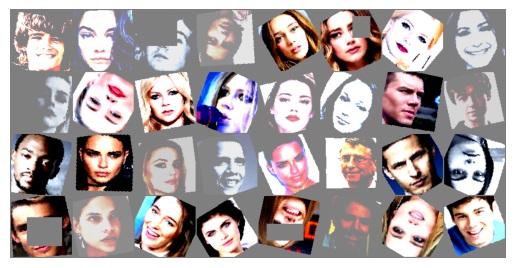

tensor(12) tensor(18) tensor(1) tensor(0)


In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [6]:
with experiment.train():
    train(model, criterion, optimizer, hyper_params, train_loader, val_loader)

Begin training...


100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


Best model saved at epoch 2 with accuracy 0.423 and loss 1.7652.
	Train Loss: 2.296 | Train Acc: 27.77777862548828%
Epoch: 02 | Epoch Time: 0m 31s
	 Val. Loss: 1.765 |  Val. Acc: 42.296072507552864%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Best model saved at epoch 3 with accuracy 0.5589 and loss 1.3444.
	Train Loss: 1.592 | Train Acc: 50.0%
Epoch: 03 | Epoch Time: 0m 28s
	 Val. Loss: 1.344 |  Val. Acc: 55.89123867069487%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.491 | Train Acc: 61.11111068725586%
Epoch: 04 | Epoch Time: 0m 27s
	 Val. Loss: 1.378 |  Val. Acc: 54.0785498489426%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Best model saved at epoch 5 with accuracy 0.5801 and loss 1.2896.
	Train Loss: 1.350 | Train Acc: 55.55555725097656%
Epoch: 05 | Epoch Time: 0m 28s
	 Val. Loss: 1.290 |  Val. Acc: 58.006042296072515%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 2.222 | Train Acc: 27.77777862548828%
Epoch: 06 | Epoch Time: 0m 27s
	 Val. Loss: 1.319 |  Val. Acc: 54.68277945619335%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Best model saved at epoch 7 with accuracy 0.5861 and loss 1.2846.
	Train Loss: 1.285 | Train Acc: 55.55555725097656%
Epoch: 07 | Epoch Time: 0m 27s
	 Val. Loss: 1.285 |  Val. Acc: 58.610271903323266%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Best model saved at epoch 8 with accuracy 0.6375 and loss 1.1091.
	Train Loss: 1.461 | Train Acc: 55.55555725097656%
Epoch: 08 | Epoch Time: 0m 27s
	 Val. Loss: 1.109 |  Val. Acc: 63.74622356495468%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.301 | Train Acc: 50.0%
Epoch: 09 | Epoch Time: 0m 29s
	 Val. Loss: 1.274 |  Val. Acc: 58.30815709969789%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.854 | Train Acc: 33.333335876464844%
Epoch: 10 | Epoch Time: 0m 28s
	 Val. Loss: 1.188 |  Val. Acc: 62.839879154078545%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Best model saved at epoch 11 with accuracy 0.6526 and loss 1.1828.
	Train Loss: 1.612 | Train Acc: 44.4444465637207%
Epoch: 11 | Epoch Time: 0m 28s
	 Val. Loss: 1.183 |  Val. Acc: 65.25679758308158%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 0.689 | Train Acc: 77.77777862548828%
Epoch: 12 | Epoch Time: 0m 27s
	 Val. Loss: 1.276 |  Val. Acc: 63.141993957703924%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.682 | Train Acc: 44.4444465637207%
Epoch: 13 | Epoch Time: 0m 28s
	 Val. Loss: 1.091 |  Val. Acc: 63.141993957703924%


100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


	Train Loss: 1.235 | Train Acc: 55.55555725097656%
Epoch: 14 | Epoch Time: 0m 28s
	 Val. Loss: 1.174 |  Val. Acc: 62.53776435045317%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.445 | Train Acc: 61.11111068725586%
Epoch: 15 | Epoch Time: 0m 28s
	 Val. Loss: 1.048 |  Val. Acc: 63.44410876132931%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 16 with accuracy 0.6798 and loss 1.03.
	Train Loss: 1.165 | Train Acc: 66.66667175292969%
Epoch: 16 | Epoch Time: 0m 27s
	 Val. Loss: 1.030 |  Val. Acc: 67.97583081570997%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 1.425 | Train Acc: 50.0%
Epoch: 17 | Epoch Time: 0m 27s
	 Val. Loss: 1.112 |  Val. Acc: 62.53776435045317%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 18 with accuracy 0.6888 and loss 1.0987.
	Train Loss: 1.603 | Train Acc: 38.88888931274414%
Epoch: 18 | Epoch Time: 0m 28s
	 Val. Loss: 1.099 |  Val. Acc: 68.8821752265861%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.968 | Train Acc: 66.66667175292969%
Epoch: 19 | Epoch Time: 0m 28s
	 Val. Loss: 1.167 |  Val. Acc: 66.16314199395771%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.179 | Train Acc: 72.22222137451172%
Epoch: 20 | Epoch Time: 0m 28s
	 Val. Loss: 1.006 |  Val. Acc: 66.16314199395771%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.241 | Train Acc: 61.11111068725586%
Epoch: 21 | Epoch Time: 0m 27s
	 Val. Loss: 1.030 |  Val. Acc: 65.25679758308158%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.906 | Train Acc: 66.66667175292969%
Epoch: 22 | Epoch Time: 0m 28s
	 Val. Loss: 1.132 |  Val. Acc: 64.35045317220543%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.507 | Train Acc: 61.11111068725586%
Epoch: 23 | Epoch Time: 0m 28s
	 Val. Loss: 1.106 |  Val. Acc: 65.55891238670695%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.797 | Train Acc: 77.77777862548828%
Epoch: 24 | Epoch Time: 0m 28s
	 Val. Loss: 1.028 |  Val. Acc: 66.76737160120845%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.997 | Train Acc: 66.66667175292969%
Epoch: 25 | Epoch Time: 0m 28s
	 Val. Loss: 1.079 |  Val. Acc: 62.2356495468278%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.840 | Train Acc: 72.22222137451172%
Epoch: 26 | Epoch Time: 0m 28s
	 Val. Loss: 0.970 |  Val. Acc: 68.27794561933534%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 0.984 | Train Acc: 72.22222137451172%
Epoch: 27 | Epoch Time: 0m 28s
	 Val. Loss: 1.087 |  Val. Acc: 64.95468277945619%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 1.687 | Train Acc: 44.4444465637207%
Epoch: 28 | Epoch Time: 0m 27s
	 Val. Loss: 1.146 |  Val. Acc: 67.97583081570997%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.929 | Train Acc: 61.11111068725586%
Epoch: 29 | Epoch Time: 0m 28s
	 Val. Loss: 1.005 |  Val. Acc: 65.55891238670695%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.535 | Train Acc: 66.66667175292969%
Epoch: 30 | Epoch Time: 0m 28s
	 Val. Loss: 1.067 |  Val. Acc: 66.76737160120845%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.693 | Train Acc: 44.4444465637207%
Epoch: 31 | Epoch Time: 0m 27s
	 Val. Loss: 1.107 |  Val. Acc: 66.46525679758308%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.019 | Train Acc: 66.66667175292969%
Epoch: 32 | Epoch Time: 0m 28s
	 Val. Loss: 0.929 |  Val. Acc: 68.8821752265861%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Best model saved at epoch 33 with accuracy 0.6979 and loss 0.9702.
	Train Loss: 1.189 | Train Acc: 61.11111068725586%
Epoch: 33 | Epoch Time: 0m 28s
	 Val. Loss: 0.970 |  Val. Acc: 69.78851963746223%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 34 with accuracy 0.71 and loss 0.9666.
	Train Loss: 1.110 | Train Acc: 72.22222137451172%
Epoch: 34 | Epoch Time: 0m 28s
	 Val. Loss: 0.967 |  Val. Acc: 70.99697885196375%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.897 | Train Acc: 77.77777862548828%
Epoch: 35 | Epoch Time: 0m 27s
	 Val. Loss: 1.163 |  Val. Acc: 67.6737160120846%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.297 | Train Acc: 61.11111068725586%
Epoch: 36 | Epoch Time: 0m 27s
	 Val. Loss: 1.175 |  Val. Acc: 65.86102719033232%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.747 | Train Acc: 44.4444465637207%
Epoch: 37 | Epoch Time: 0m 27s
	 Val. Loss: 1.033 |  Val. Acc: 65.86102719033232%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.104 | Train Acc: 61.11111068725586%
Epoch: 38 | Epoch Time: 0m 27s
	 Val. Loss: 1.288 |  Val. Acc: 62.2356495468278%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.894 | Train Acc: 66.66667175292969%
Epoch: 39 | Epoch Time: 0m 28s
	 Val. Loss: 0.949 |  Val. Acc: 70.99697885196375%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.657 | Train Acc: 77.77777862548828%
Epoch: 40 | Epoch Time: 0m 27s
	 Val. Loss: 1.058 |  Val. Acc: 67.06948640483384%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.864 | Train Acc: 77.77777862548828%
Epoch: 41 | Epoch Time: 0m 27s
	 Val. Loss: 1.036 |  Val. Acc: 68.58006042296071%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.820 | Train Acc: 66.66667175292969%
Epoch: 42 | Epoch Time: 0m 27s
	 Val. Loss: 0.977 |  Val. Acc: 68.8821752265861%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.719 | Train Acc: 77.77777862548828%
Epoch: 43 | Epoch Time: 0m 28s
	 Val. Loss: 0.958 |  Val. Acc: 67.97583081570997%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.348 | Train Acc: 66.66667175292969%
Epoch: 44 | Epoch Time: 0m 28s
	 Val. Loss: 1.086 |  Val. Acc: 66.46525679758308%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.148 | Train Acc: 66.66667175292969%
Epoch: 45 | Epoch Time: 0m 28s
	 Val. Loss: 1.139 |  Val. Acc: 70.09063444108762%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.065 | Train Acc: 61.11111068725586%
Epoch: 46 | Epoch Time: 0m 28s
	 Val. Loss: 1.039 |  Val. Acc: 69.18429003021149%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 1.013 | Train Acc: 61.11111068725586%
Epoch: 47 | Epoch Time: 0m 27s
	 Val. Loss: 0.990 |  Val. Acc: 69.48640483383686%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.839 | Train Acc: 77.77777862548828%
Epoch: 48 | Epoch Time: 0m 27s
	 Val. Loss: 0.997 |  Val. Acc: 68.8821752265861%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.621 | Train Acc: 77.77777862548828%
Epoch: 49 | Epoch Time: 0m 28s
	 Val. Loss: 1.104 |  Val. Acc: 69.18429003021149%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.811 | Train Acc: 72.22222137451172%
Epoch: 50 | Epoch Time: 0m 28s
	 Val. Loss: 1.318 |  Val. Acc: 66.76737160120845%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.532 | Train Acc: 50.0%
Epoch: 51 | Epoch Time: 0m 28s
	 Val. Loss: 0.947 |  Val. Acc: 69.48640483383686%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.744 | Train Acc: 72.22222137451172%
Epoch: 52 | Epoch Time: 0m 27s
	 Val. Loss: 0.905 |  Val. Acc: 69.48640483383686%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.558 | Train Acc: 44.4444465637207%
Epoch: 53 | Epoch Time: 0m 28s
	 Val. Loss: 0.919 |  Val. Acc: 70.39274924471299%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.168 | Train Acc: 44.4444465637207%
Epoch: 54 | Epoch Time: 0m 28s
	 Val. Loss: 0.892 |  Val. Acc: 70.39274924471299%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.188 | Train Acc: 44.4444465637207%
Epoch: 55 | Epoch Time: 0m 27s
	 Val. Loss: 1.051 |  Val. Acc: 67.97583081570997%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.105 | Train Acc: 55.55555725097656%
Epoch: 56 | Epoch Time: 0m 28s
	 Val. Loss: 0.978 |  Val. Acc: 70.69486404833837%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.050 | Train Acc: 72.22222137451172%
Epoch: 57 | Epoch Time: 0m 28s
	 Val. Loss: 1.080 |  Val. Acc: 66.46525679758308%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Best model saved at epoch 58 with accuracy 0.713 and loss 0.9566.
	Train Loss: 0.532 | Train Acc: 77.77777862548828%
Epoch: 58 | Epoch Time: 0m 28s
	 Val. Loss: 0.957 |  Val. Acc: 71.29909365558912%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Best model saved at epoch 59 with accuracy 0.716 and loss 0.9534.
	Train Loss: 1.178 | Train Acc: 66.66667175292969%
Epoch: 59 | Epoch Time: 0m 27s
	 Val. Loss: 0.953 |  Val. Acc: 71.6012084592145%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.580 | Train Acc: 72.22222137451172%
Epoch: 60 | Epoch Time: 0m 28s
	 Val. Loss: 0.989 |  Val. Acc: 70.69486404833837%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.318 | Train Acc: 61.11111068725586%
Epoch: 61 | Epoch Time: 0m 28s
	 Val. Loss: 1.138 |  Val. Acc: 68.58006042296071%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.978 | Train Acc: 66.66667175292969%
Epoch: 62 | Epoch Time: 0m 28s
	 Val. Loss: 0.895 |  Val. Acc: 69.78851963746223%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.145 | Train Acc: 55.55555725097656%
Epoch: 63 | Epoch Time: 0m 28s
	 Val. Loss: 0.924 |  Val. Acc: 70.39274924471299%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.824 | Train Acc: 72.22222137451172%
Epoch: 64 | Epoch Time: 0m 28s
	 Val. Loss: 0.943 |  Val. Acc: 70.99697885196375%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 0.903 | Train Acc: 83.33332824707031%
Epoch: 65 | Epoch Time: 0m 28s
	 Val. Loss: 0.984 |  Val. Acc: 70.99697885196375%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Best model saved at epoch 66 with accuracy 0.719 and loss 0.9705.
	Train Loss: 1.025 | Train Acc: 66.66667175292969%
Epoch: 66 | Epoch Time: 0m 28s
	 Val. Loss: 0.970 |  Val. Acc: 71.90332326283988%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.799 | Train Acc: 83.33332824707031%
Epoch: 67 | Epoch Time: 0m 28s
	 Val. Loss: 1.032 |  Val. Acc: 70.69486404833837%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.749 | Train Acc: 72.22222137451172%
Epoch: 68 | Epoch Time: 0m 28s
	 Val. Loss: 1.105 |  Val. Acc: 68.8821752265861%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.896 | Train Acc: 72.22222137451172%
Epoch: 69 | Epoch Time: 0m 28s
	 Val. Loss: 1.040 |  Val. Acc: 70.69486404833837%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.917 | Train Acc: 66.66667175292969%
Epoch: 70 | Epoch Time: 0m 28s
	 Val. Loss: 1.057 |  Val. Acc: 70.39274924471299%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.826 | Train Acc: 77.77777862548828%
Epoch: 71 | Epoch Time: 0m 28s
	 Val. Loss: 0.920 |  Val. Acc: 68.8821752265861%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Best model saved at epoch 72 with accuracy 0.7402 and loss 0.856.
	Train Loss: 0.916 | Train Acc: 72.22222137451172%
Epoch: 72 | Epoch Time: 0m 28s
	 Val. Loss: 0.856 |  Val. Acc: 74.01812688821752%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 0.940 | Train Acc: 77.77777862548828%
Epoch: 73 | Epoch Time: 0m 28s
	 Val. Loss: 0.982 |  Val. Acc: 71.90332326283988%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.108 | Train Acc: 66.66667175292969%
Epoch: 74 | Epoch Time: 0m 28s
	 Val. Loss: 0.859 |  Val. Acc: 74.01812688821752%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.901 | Train Acc: 66.66667175292969%
Epoch: 75 | Epoch Time: 0m 28s
	 Val. Loss: 0.923 |  Val. Acc: 72.20543806646525%


100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


Best model saved at epoch 76 with accuracy 0.7674 and loss 0.8736.
	Train Loss: 1.028 | Train Acc: 66.66667175292969%
Epoch: 76 | Epoch Time: 0m 28s
	 Val. Loss: 0.874 |  Val. Acc: 76.73716012084593%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.731 | Train Acc: 77.77777862548828%
Epoch: 77 | Epoch Time: 0m 28s
	 Val. Loss: 0.901 |  Val. Acc: 73.41389728096676%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.635 | Train Acc: 77.77777862548828%
Epoch: 78 | Epoch Time: 0m 28s
	 Val. Loss: 0.940 |  Val. Acc: 72.80966767371602%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.482 | Train Acc: 55.55555725097656%
Epoch: 79 | Epoch Time: 0m 27s
	 Val. Loss: 0.837 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.009 | Train Acc: 61.11111068725586%
Epoch: 80 | Epoch Time: 0m 27s
	 Val. Loss: 0.824 |  Val. Acc: 74.01812688821752%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 0.269 | Train Acc: 94.44445037841797%
Epoch: 81 | Epoch Time: 0m 28s
	 Val. Loss: 0.939 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.186 | Train Acc: 50.0%
Epoch: 82 | Epoch Time: 0m 28s
	 Val. Loss: 0.867 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.462 | Train Acc: 77.77777862548828%
Epoch: 83 | Epoch Time: 0m 28s
	 Val. Loss: 0.918 |  Val. Acc: 70.09063444108762%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.886 | Train Acc: 77.77777862548828%
Epoch: 84 | Epoch Time: 0m 28s
	 Val. Loss: 1.013 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.604 | Train Acc: 77.77777862548828%
Epoch: 85 | Epoch Time: 0m 28s
	 Val. Loss: 0.851 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 0.691 | Train Acc: 77.77777862548828%
Epoch: 86 | Epoch Time: 0m 27s
	 Val. Loss: 0.894 |  Val. Acc: 69.78851963746223%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.688 | Train Acc: 77.77777862548828%
Epoch: 87 | Epoch Time: 0m 27s
	 Val. Loss: 1.129 |  Val. Acc: 67.06948640483384%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.741 | Train Acc: 77.77777862548828%
Epoch: 88 | Epoch Time: 0m 27s
	 Val. Loss: 0.952 |  Val. Acc: 73.41389728096676%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Best model saved at epoch 89 with accuracy 0.7704 and loss 0.8493.
	Train Loss: 0.762 | Train Acc: 83.33332824707031%
Epoch: 89 | Epoch Time: 0m 27s
	 Val. Loss: 0.849 |  Val. Acc: 77.0392749244713%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.775 | Train Acc: 77.77777862548828%
Epoch: 90 | Epoch Time: 0m 27s
	 Val. Loss: 0.984 |  Val. Acc: 71.90332326283988%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 1.081 | Train Acc: 61.11111068725586%
Epoch: 91 | Epoch Time: 0m 27s
	 Val. Loss: 0.966 |  Val. Acc: 72.20543806646525%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.341 | Train Acc: 61.11111068725586%
Epoch: 92 | Epoch Time: 0m 27s
	 Val. Loss: 1.045 |  Val. Acc: 72.80966767371602%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.461 | Train Acc: 83.33332824707031%
Epoch: 93 | Epoch Time: 0m 27s
	 Val. Loss: 0.994 |  Val. Acc: 71.6012084592145%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.705 | Train Acc: 66.66667175292969%
Epoch: 94 | Epoch Time: 0m 27s
	 Val. Loss: 0.973 |  Val. Acc: 71.29909365558912%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.633 | Train Acc: 72.22222137451172%
Epoch: 95 | Epoch Time: 0m 28s
	 Val. Loss: 0.812 |  Val. Acc: 73.71601208459214%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.769 | Train Acc: 66.66667175292969%
Epoch: 96 | Epoch Time: 0m 27s
	 Val. Loss: 0.960 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 1.124 | Train Acc: 61.11111068725586%
Epoch: 97 | Epoch Time: 0m 27s
	 Val. Loss: 0.922 |  Val. Acc: 73.71601208459214%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 1.010 | Train Acc: 61.11111068725586%
Epoch: 98 | Epoch Time: 0m 27s
	 Val. Loss: 0.790 |  Val. Acc: 76.73716012084593%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.947 | Train Acc: 66.66667175292969%
Epoch: 99 | Epoch Time: 0m 27s
	 Val. Loss: 0.971 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.598 | Train Acc: 83.33332824707031%
Epoch: 100 | Epoch Time: 0m 27s
	 Val. Loss: 0.866 |  Val. Acc: 73.71601208459214%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.518 | Train Acc: 77.77777862548828%
Epoch: 101 | Epoch Time: 0m 27s
	 Val. Loss: 0.858 |  Val. Acc: 72.80966767371602%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.398 | Train Acc: 83.33332824707031%
Epoch: 102 | Epoch Time: 0m 28s
	 Val. Loss: 0.932 |  Val. Acc: 73.1117824773414%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.663 | Train Acc: 83.33332824707031%
Epoch: 103 | Epoch Time: 0m 28s
	 Val. Loss: 0.976 |  Val. Acc: 72.20543806646525%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.345 | Train Acc: 88.8888931274414%
Epoch: 104 | Epoch Time: 0m 28s
	 Val. Loss: 0.907 |  Val. Acc: 73.41389728096676%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.037 | Train Acc: 66.66667175292969%
Epoch: 105 | Epoch Time: 0m 28s
	 Val. Loss: 0.945 |  Val. Acc: 71.90332326283988%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.822 | Train Acc: 77.77777862548828%
Epoch: 106 | Epoch Time: 0m 28s
	 Val. Loss: 0.905 |  Val. Acc: 70.09063444108762%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.496 | Train Acc: 77.77777862548828%
Epoch: 107 | Epoch Time: 0m 28s
	 Val. Loss: 0.801 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.748 | Train Acc: 61.11111068725586%
Epoch: 108 | Epoch Time: 0m 28s
	 Val. Loss: 0.826 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.829 | Train Acc: 66.66667175292969%
Epoch: 109 | Epoch Time: 0m 28s
	 Val. Loss: 0.803 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 0.446 | Train Acc: 88.8888931274414%
Epoch: 110 | Epoch Time: 0m 28s
	 Val. Loss: 0.949 |  Val. Acc: 73.1117824773414%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 111 with accuracy 0.7734 and loss 0.6788.
	Train Loss: 0.596 | Train Acc: 77.77777862548828%
Epoch: 111 | Epoch Time: 0m 28s
	 Val. Loss: 0.679 |  Val. Acc: 77.34138972809667%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.753 | Train Acc: 83.33332824707031%
Epoch: 112 | Epoch Time: 0m 28s
	 Val. Loss: 0.767 |  Val. Acc: 77.34138972809667%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.904 | Train Acc: 83.33332824707031%
Epoch: 113 | Epoch Time: 0m 28s
	 Val. Loss: 0.853 |  Val. Acc: 76.43504531722054%


100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


	Train Loss: 1.558 | Train Acc: 55.55555725097656%
Epoch: 114 | Epoch Time: 0m 28s
	 Val. Loss: 0.818 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.798 | Train Acc: 61.11111068725586%
Epoch: 115 | Epoch Time: 0m 28s
	 Val. Loss: 0.834 |  Val. Acc: 76.43504531722054%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.486 | Train Acc: 77.77777862548828%
Epoch: 116 | Epoch Time: 0m 28s
	 Val. Loss: 0.998 |  Val. Acc: 74.01812688821752%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.669 | Train Acc: 77.77777862548828%
Epoch: 117 | Epoch Time: 0m 28s
	 Val. Loss: 0.947 |  Val. Acc: 77.0392749244713%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.615 | Train Acc: 72.22222137451172%
Epoch: 118 | Epoch Time: 0m 28s
	 Val. Loss: 0.916 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.584 | Train Acc: 83.33332824707031%
Epoch: 119 | Epoch Time: 0m 28s
	 Val. Loss: 0.959 |  Val. Acc: 74.32024169184291%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.844 | Train Acc: 77.77777862548828%
Epoch: 120 | Epoch Time: 0m 28s
	 Val. Loss: 0.920 |  Val. Acc: 72.80966767371602%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.450 | Train Acc: 83.33332824707031%
Epoch: 121 | Epoch Time: 0m 28s
	 Val. Loss: 0.886 |  Val. Acc: 73.41389728096676%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.601 | Train Acc: 83.33332824707031%
Epoch: 122 | Epoch Time: 0m 28s
	 Val. Loss: 0.805 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 1.068 | Train Acc: 66.66667175292969%
Epoch: 123 | Epoch Time: 0m 28s
	 Val. Loss: 0.955 |  Val. Acc: 71.6012084592145%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.649 | Train Acc: 77.77777862548828%
Epoch: 124 | Epoch Time: 0m 28s
	 Val. Loss: 0.879 |  Val. Acc: 73.71601208459214%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.723 | Train Acc: 77.77777862548828%
Epoch: 125 | Epoch Time: 0m 28s
	 Val. Loss: 0.746 |  Val. Acc: 74.62235649546828%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.595 | Train Acc: 77.77777862548828%
Epoch: 126 | Epoch Time: 0m 28s
	 Val. Loss: 0.958 |  Val. Acc: 72.80966767371602%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.721 | Train Acc: 72.22222137451172%
Epoch: 127 | Epoch Time: 0m 28s
	 Val. Loss: 0.850 |  Val. Acc: 77.0392749244713%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.592 | Train Acc: 77.77777862548828%
Epoch: 128 | Epoch Time: 0m 28s
	 Val. Loss: 0.917 |  Val. Acc: 74.32024169184291%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.241 | Train Acc: 94.44445037841797%
Epoch: 129 | Epoch Time: 0m 27s
	 Val. Loss: 1.000 |  Val. Acc: 73.41389728096676%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.562 | Train Acc: 83.33332824707031%
Epoch: 130 | Epoch Time: 0m 27s
	 Val. Loss: 0.989 |  Val. Acc: 72.80966767371602%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.558 | Train Acc: 83.33332824707031%
Epoch: 131 | Epoch Time: 0m 28s
	 Val. Loss: 0.948 |  Val. Acc: 73.71601208459214%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.175 | Train Acc: 55.55555725097656%
Epoch: 132 | Epoch Time: 0m 28s
	 Val. Loss: 0.798 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.544 | Train Acc: 88.8888931274414%
Epoch: 133 | Epoch Time: 0m 28s
	 Val. Loss: 0.856 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 0.210 | Train Acc: 94.44445037841797%
Epoch: 134 | Epoch Time: 0m 29s
	 Val. Loss: 0.834 |  Val. Acc: 77.34138972809667%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.532 | Train Acc: 94.44445037841797%
Epoch: 135 | Epoch Time: 0m 28s
	 Val. Loss: 1.104 |  Val. Acc: 71.90332326283988%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.797 | Train Acc: 77.77777862548828%
Epoch: 136 | Epoch Time: 0m 28s
	 Val. Loss: 0.894 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.172 | Train Acc: 94.44445037841797%
Epoch: 137 | Epoch Time: 0m 28s
	 Val. Loss: 0.856 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.145 | Train Acc: 77.77777862548828%
Epoch: 138 | Epoch Time: 0m 29s
	 Val. Loss: 0.881 |  Val. Acc: 74.01812688821752%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 0.802 | Train Acc: 72.22222137451172%
Epoch: 139 | Epoch Time: 0m 27s
	 Val. Loss: 0.848 |  Val. Acc: 76.43504531722054%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.876 | Train Acc: 66.66667175292969%
Epoch: 140 | Epoch Time: 0m 27s
	 Val. Loss: 0.912 |  Val. Acc: 73.41389728096676%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.873 | Train Acc: 83.33332824707031%
Epoch: 141 | Epoch Time: 0m 28s
	 Val. Loss: 0.886 |  Val. Acc: 73.71601208459214%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.058 | Train Acc: 61.11111068725586%
Epoch: 142 | Epoch Time: 0m 28s
	 Val. Loss: 0.814 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.082 | Train Acc: 61.11111068725586%
Epoch: 143 | Epoch Time: 0m 29s
	 Val. Loss: 0.983 |  Val. Acc: 76.73716012084593%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.537 | Train Acc: 88.8888931274414%
Epoch: 144 | Epoch Time: 0m 29s
	 Val. Loss: 0.877 |  Val. Acc: 75.83081570996978%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.955 | Train Acc: 72.22222137451172%
Epoch: 145 | Epoch Time: 0m 29s
	 Val. Loss: 0.841 |  Val. Acc: 77.34138972809667%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.817 | Train Acc: 72.22222137451172%
Epoch: 146 | Epoch Time: 0m 28s
	 Val. Loss: 0.864 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 0.731 | Train Acc: 72.22222137451172%
Epoch: 147 | Epoch Time: 0m 28s
	 Val. Loss: 0.905 |  Val. Acc: 73.41389728096676%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 0.613 | Train Acc: 77.77777862548828%
Epoch: 148 | Epoch Time: 0m 28s
	 Val. Loss: 0.843 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 0.620 | Train Acc: 72.22222137451172%
Epoch: 149 | Epoch Time: 0m 29s
	 Val. Loss: 0.951 |  Val. Acc: 73.1117824773414%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.792 | Train Acc: 66.66667175292969%
Epoch: 150 | Epoch Time: 0m 29s
	 Val. Loss: 0.914 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.675 | Train Acc: 72.22222137451172%
Epoch: 151 | Epoch Time: 0m 29s
	 Val. Loss: 0.823 |  Val. Acc: 75.83081570996978%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.460 | Train Acc: 88.8888931274414%
Epoch: 152 | Epoch Time: 0m 28s
	 Val. Loss: 0.861 |  Val. Acc: 74.62235649546828%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.206 | Train Acc: 66.66667175292969%
Epoch: 153 | Epoch Time: 0m 29s
	 Val. Loss: 0.951 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.582 | Train Acc: 83.33332824707031%
Epoch: 154 | Epoch Time: 0m 28s
	 Val. Loss: 1.020 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 0.686 | Train Acc: 72.22222137451172%
Epoch: 155 | Epoch Time: 0m 29s
	 Val. Loss: 0.926 |  Val. Acc: 77.0392749244713%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.707 | Train Acc: 88.8888931274414%
Epoch: 156 | Epoch Time: 0m 28s
	 Val. Loss: 1.041 |  Val. Acc: 73.71601208459214%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.285 | Train Acc: 88.8888931274414%
Epoch: 157 | Epoch Time: 0m 28s
	 Val. Loss: 0.976 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.859 | Train Acc: 77.77777862548828%
Epoch: 158 | Epoch Time: 0m 29s
	 Val. Loss: 1.128 |  Val. Acc: 73.1117824773414%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.746 | Train Acc: 83.33332824707031%
Epoch: 159 | Epoch Time: 0m 28s
	 Val. Loss: 1.100 |  Val. Acc: 74.01812688821752%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Best model saved at epoch 160 with accuracy 0.7915 and loss 0.8686.
	Train Loss: 0.477 | Train Acc: 88.8888931274414%
Epoch: 160 | Epoch Time: 0m 28s
	 Val. Loss: 0.869 |  Val. Acc: 79.15407854984893%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.653 | Train Acc: 83.33332824707031%
Epoch: 161 | Epoch Time: 0m 28s
	 Val. Loss: 0.841 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.883 | Train Acc: 77.77777862548828%
Epoch: 162 | Epoch Time: 0m 29s
	 Val. Loss: 0.886 |  Val. Acc: 74.32024169184291%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.170 | Train Acc: 100.0%
Epoch: 163 | Epoch Time: 0m 29s
	 Val. Loss: 0.819 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 1.001 | Train Acc: 61.11111068725586%
Epoch: 164 | Epoch Time: 0m 28s
	 Val. Loss: 0.881 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.134 | Train Acc: 100.0%
Epoch: 165 | Epoch Time: 0m 28s
	 Val. Loss: 0.952 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.325 | Train Acc: 88.8888931274414%
Epoch: 166 | Epoch Time: 0m 28s
	 Val. Loss: 0.902 |  Val. Acc: 76.43504531722054%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.391 | Train Acc: 77.77777862548828%
Epoch: 167 | Epoch Time: 0m 28s
	 Val. Loss: 0.904 |  Val. Acc: 77.94561933534743%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 0.748 | Train Acc: 77.77777862548828%
Epoch: 168 | Epoch Time: 0m 28s
	 Val. Loss: 0.888 |  Val. Acc: 75.83081570996978%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.199 | Train Acc: 94.44445037841797%
Epoch: 169 | Epoch Time: 0m 28s
	 Val. Loss: 1.106 |  Val. Acc: 75.83081570996978%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 0.550 | Train Acc: 83.33332824707031%
Epoch: 170 | Epoch Time: 0m 28s
	 Val. Loss: 0.917 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.463 | Train Acc: 83.33332824707031%
Epoch: 171 | Epoch Time: 0m 28s
	 Val. Loss: 0.758 |  Val. Acc: 79.15407854984893%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.108 | Train Acc: 100.0%
Epoch: 172 | Epoch Time: 0m 29s
	 Val. Loss: 0.726 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.123 | Train Acc: 94.44445037841797%
Epoch: 173 | Epoch Time: 0m 30s
	 Val. Loss: 0.864 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.579 | Train Acc: 83.33332824707031%
Epoch: 174 | Epoch Time: 0m 29s
	 Val. Loss: 0.950 |  Val. Acc: 74.62235649546828%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.817 | Train Acc: 77.77777862548828%
Epoch: 175 | Epoch Time: 0m 29s
	 Val. Loss: 0.898 |  Val. Acc: 76.43504531722054%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.770 | Train Acc: 66.66667175292969%
Epoch: 176 | Epoch Time: 0m 29s
	 Val. Loss: 0.828 |  Val. Acc: 77.64350453172206%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.169 | Train Acc: 100.0%
Epoch: 177 | Epoch Time: 0m 29s
	 Val. Loss: 1.023 |  Val. Acc: 73.1117824773414%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 0.820 | Train Acc: 66.66667175292969%
Epoch: 178 | Epoch Time: 0m 29s
	 Val. Loss: 0.838 |  Val. Acc: 76.13293051359517%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.770 | Train Acc: 77.77777862548828%
Epoch: 179 | Epoch Time: 0m 29s
	 Val. Loss: 0.909 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.192 | Train Acc: 94.44445037841797%
Epoch: 180 | Epoch Time: 0m 29s
	 Val. Loss: 1.056 |  Val. Acc: 72.50755287009063%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.242 | Train Acc: 94.44445037841797%
Epoch: 181 | Epoch Time: 0m 29s
	 Val. Loss: 0.909 |  Val. Acc: 78.85196374622356%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.867 | Train Acc: 77.77777862548828%
Epoch: 182 | Epoch Time: 0m 29s
	 Val. Loss: 0.825 |  Val. Acc: 79.15407854984893%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.461 | Train Acc: 88.8888931274414%
Epoch: 183 | Epoch Time: 0m 29s
	 Val. Loss: 0.885 |  Val. Acc: 76.43504531722054%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.671 | Train Acc: 83.33332824707031%
Epoch: 184 | Epoch Time: 0m 29s
	 Val. Loss: 0.808 |  Val. Acc: 78.54984894259819%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 0.586 | Train Acc: 77.77777862548828%
Epoch: 185 | Epoch Time: 0m 29s
	 Val. Loss: 0.911 |  Val. Acc: 76.43504531722054%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.261 | Train Acc: 94.44445037841797%
Epoch: 186 | Epoch Time: 0m 29s
	 Val. Loss: 1.022 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 0.620 | Train Acc: 77.77777862548828%
Epoch: 187 | Epoch Time: 0m 29s
	 Val. Loss: 0.903 |  Val. Acc: 74.32024169184291%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 0.257 | Train Acc: 88.8888931274414%
Epoch: 188 | Epoch Time: 0m 29s
	 Val. Loss: 0.899 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.747 | Train Acc: 77.77777862548828%
Epoch: 189 | Epoch Time: 0m 29s
	 Val. Loss: 1.022 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 0.741 | Train Acc: 72.22222137451172%
Epoch: 190 | Epoch Time: 0m 29s
	 Val. Loss: 1.094 |  Val. Acc: 77.0392749244713%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.401 | Train Acc: 83.33332824707031%
Epoch: 191 | Epoch Time: 0m 29s
	 Val. Loss: 1.077 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.833 | Train Acc: 72.22222137451172%
Epoch: 192 | Epoch Time: 0m 29s
	 Val. Loss: 0.914 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 0.629 | Train Acc: 83.33332824707031%
Epoch: 193 | Epoch Time: 0m 29s
	 Val. Loss: 0.829 |  Val. Acc: 77.94561933534743%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.635 | Train Acc: 88.8888931274414%
Epoch: 194 | Epoch Time: 0m 29s
	 Val. Loss: 0.892 |  Val. Acc: 78.24773413897282%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 0.907 | Train Acc: 77.77777862548828%
Epoch: 195 | Epoch Time: 0m 29s
	 Val. Loss: 0.954 |  Val. Acc: 74.92447129909365%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 0.177 | Train Acc: 100.0%
Epoch: 196 | Epoch Time: 0m 29s
	 Val. Loss: 0.826 |  Val. Acc: 77.64350453172206%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 0.522 | Train Acc: 88.8888931274414%
Epoch: 197 | Epoch Time: 0m 29s
	 Val. Loss: 0.748 |  Val. Acc: 77.94561933534743%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 0.779 | Train Acc: 77.77777862548828%
Epoch: 198 | Epoch Time: 0m 29s
	 Val. Loss: 0.885 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 0.202 | Train Acc: 94.44445037841797%
Epoch: 199 | Epoch Time: 0m 29s
	 Val. Loss: 0.844 |  Val. Acc: 75.22658610271903%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


	Train Loss: 0.188 | Train Acc: 94.44445037841797%
Epoch: 200 | Epoch Time: 0m 29s
	 Val. Loss: 0.975 |  Val. Acc: 75.52870090634441%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

	Train Loss: 0.242 | Train Acc: 88.8888931274414%
Epoch: 201 | Epoch Time: 0m 29s
	 Val. Loss: 0.987 |  Val. Acc: 74.92447129909365%


In [7]:
with experiment.test():

    model.load_state_dict(torch.load(hyper_params['best_model_path'])) #Loading the state dict into the model
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, experiment) 
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

Test Loss: 0.821 | Test Acc: 77.89%


In [8]:
confusion(model, test_loader, device = device, experiment=experiment)

In [9]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/beb064d223574062846cf676b2988311
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [11]           : (6.25, 77.89256247607145)
COMET INFO:     test_loss [11]          : (0.13511320677670566, 0.821392836895856)
COMET INFO:     train_acc [16600]       : (0.0, 1.0)
COMET INFO:     train_loss [16600]      : (0.08674916625022888, 4.421513080596924)
COMET INFO:     train_step_time [16600] : (0, 2)
COMET INFO:     train_val_acc [200]     : (0.4229607250755287, 0.7915407854984894)
COMET INFO:     train_val_loss [200]    : (0.6787634844129736, 1.7651581980965354)
COMET INFO:   Parameters:
COMET INFO:     batch_size           : 32
COMET INFO:     best_model_path      : output/MN3LCB_celebs20.pt
COMET INFO:     comet_